In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.stats import norm
from astropy.io import fits
import math
from scipy import constants as c
%matplotlib inline

In [2]:
cd ..

/users/anneke


In [3]:
cd scratch3


/scratch3/users/anneke


In [4]:
cd HST/


/scratch3/users/anneke/HST


In [5]:
ls

 0III_bshbh_goodsn.pdf                   gn3_01.H.1060.2d.fits
 0III_bshbh_goodsn2.pdf                  gn3_01.K.1060.2d.fits
 0III_bshbh_goodsn5.pdf                  gn3_04.K.12302.2d.fits
 Graph_A.png                             goodsn-42-G141-big_01060.2D.fits
 Graph_A1.png                            goodsn-42-G141-big_01060.new_zfit.fits
'OIII Gaussian.png'                      goodsn-42-G141_01060.1D.fits
 OIII_SourceA.png                        goodsn-42-G141_01060.2D.fits
 OIII_SourceA2.png                       goodsn-42-G141_01060.linefit.fits
 OIII_SourceB.png                        graph1.png
 OIII_SourceB2.png                       graph2.png
 Spectral_image_data.ipynb               hst_F125W_BSMBH.fits
 Unknown.png                             hst_F160W_BSMBH.fits
 Untitled.ipynb                          hst_F435W_BSMBH.fits
 Untitled1.ipynb                         hst_F606W_BSMBH.fits
 bright_model_no_parallel_2-image.fits   hst_F775W_BSMBH.fits
 fig1.png                  

In [6]:


#plt.rcParams['figure.figsize'] = (20,10)


hdu = fits.open("goodsn-42-G141_01060.2D.fits")
flux = hdu['SCI'].data[22,110:140]
wavelength = hdu['SCI'].data[20:25,120]  #pixels representing wavelength

# To find: p and m2. I have vr: v2/v1 and the error there in. The model function calculates a value from the equation for binary systems and should input different random values for p and m2 as defined in their prior range. 
#the output must be compared to the prior for vr and must be close to the vr value.

#start by defining the model function
v2=-3.75e11 #km/year
v1=21713976790.253414 #km/year
delta_v=abs(v1-v2)
print('DeltaV=', delta_v, 'km/year')
G=1.327e11 #km^3 (solar mass)^-1 years^-2
#from log10(log stellar mass/Msun) = 10.54, stellar mass (stm) aka m1+m2= 3.47 × 10^10  solar masses
stm= 3.47e10 #solar masses

def smbh2_model(theta,stm=stm):
    p,m2,m1=theta
    sin3=2/3 #estimate
    numerator = (m1+m2) * 2 * math.pi * G * sin3
    denominator = p
    cube_root = (numerator / denominator) ** (1/3)
    delta_v = cube_root - 2 * v1

    return delta_v

#def kepler_model(theta):
  #  m1,m2,P = theta
  #  sin3i = 2/3
  #  return np.log10(((2*c.pi*G*sin3i*(m1+m2))/P)**(1/3))
#We now need a function referred to as lnlike().This function takes as an argument theta as well as the x,y,  and yerr of the actual theta. It should return a number corresponding to how good a fit the model is to my data given a set of parameters
#weighted by the error in my data points (the error in v_offset calcs)
# y is the value of vr and yerr the value of the error in the calcs. ?

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y -kepler_model(theta))/yerr) ** 2)

#lnprior function is used to check that all variables are within their priors (here the priors are set)
#emcee requires 0.0 returned if all priors are satisfied. if not function returns -np.inf
def lnprior(theta):
    p, m2, m1 =theta
    if (1<p< 1e5) and (1e4<m2< 1e6) and (1e4<m1< 1e6) and (1e10<m1+m2<4e10):
        return 0.0

    return -np.inf 
#one model to rule them all
# lnprob combines the above steps by running lnprior and if np.inf is returned passe
def lnprob(theta, x, y, yerr):
    lp=lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)
    

#We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC: use 1000 (arbitrary)

#We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts).

#Finally we need p0, which is the methodology of stepping from one place to a grid to the next 
yerr_val=1000
#err and data left out
data=(wavelength, flux, yerr_val)
nwalkers = 500
niter = 1000
initial = np.array([1e5, 1e6, 1e3]) #m1,m2,p
ndim = len(initial)
# Randomly sample initial state for walkers (assuming uniform priors)
p0 = [np.array(initial) + 100 * np.random.randn(ndim) for i in range(nwalkers)]




#p0 = random_initialization(nwalkers, ndim, lower_bounds, upper_bounds)
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print(data)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)


    return sampler, pos, prob, state

DeltaV= 396713976790.2534 km/year


In [7]:
 sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

(array([0.12441757, 0.11663651, 0.127021  , 0.10297639, 0.09852233]), array([0.07025735, 0.10124537, 0.08127703, 0.08352374, 0.0865227 ,
       0.08374514, 0.07721471, 0.07999526, 0.083603  , 0.09660716,
       0.127021  , 0.10731463, 0.15107947, 0.1955422 , 0.20785707,
       0.17753332, 0.20437395, 0.25618986, 0.29427448, 0.32659609,
       0.19281928, 0.12941686, 0.09991945, 0.09852149, 0.0953414 ,
       0.07620114, 0.07649414, 0.08685088, 0.07438385, 0.0758074 ]), 1000)
Running burn-in...


/usr/local/lib/python3.8/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


In [8]:
samples=sampler.flatchain
diff= samples[:,1]-samples[:,2]

Niter= 1000 NWalkers 500
Initial [ 100000. 1000000.    1000.] m1,m2,p


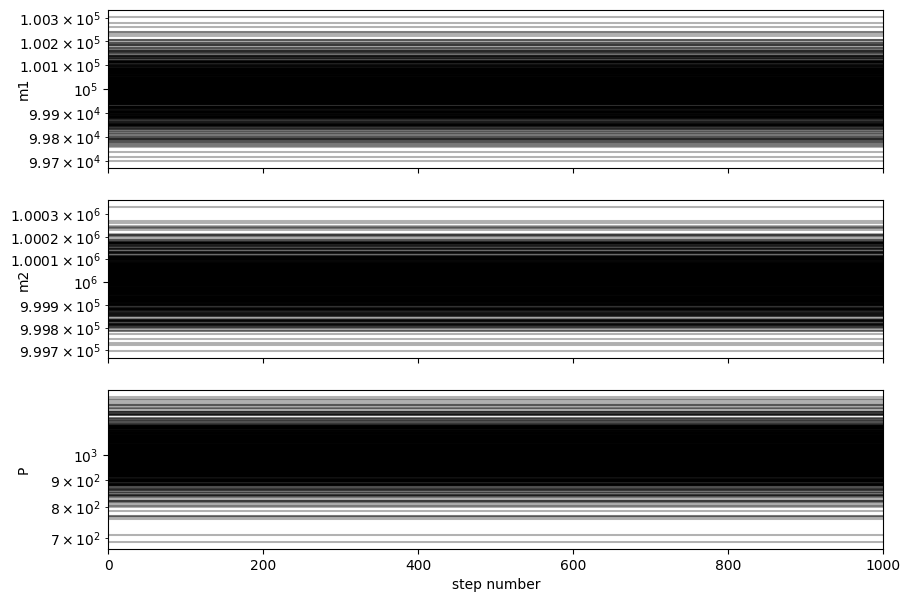

In [9]:
#plot chain values
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "P","sin3i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3,rasterized=True)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_yscale("log")

axes[-1].set_xlabel("step number")
print('Niter=', niter, 'NWalkers', nwalkers)
print('Initial', initial, "m1,m2,p")
      


<function matplotlib.pyplot.show(close=None, block=None)>

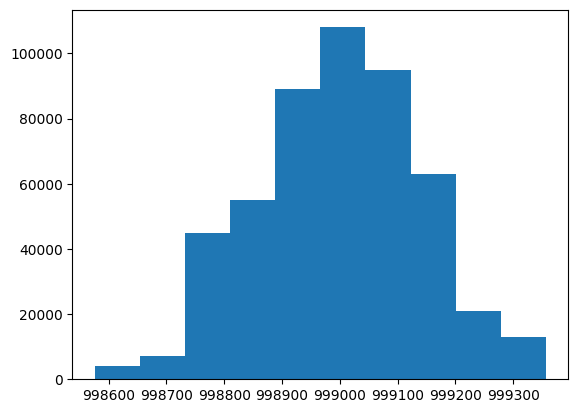

In [10]:
plt.hist(diff)
plt.show

/usr/local/lib/python3.8/dist-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (500). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


nwalkers is 500
niter is 1000


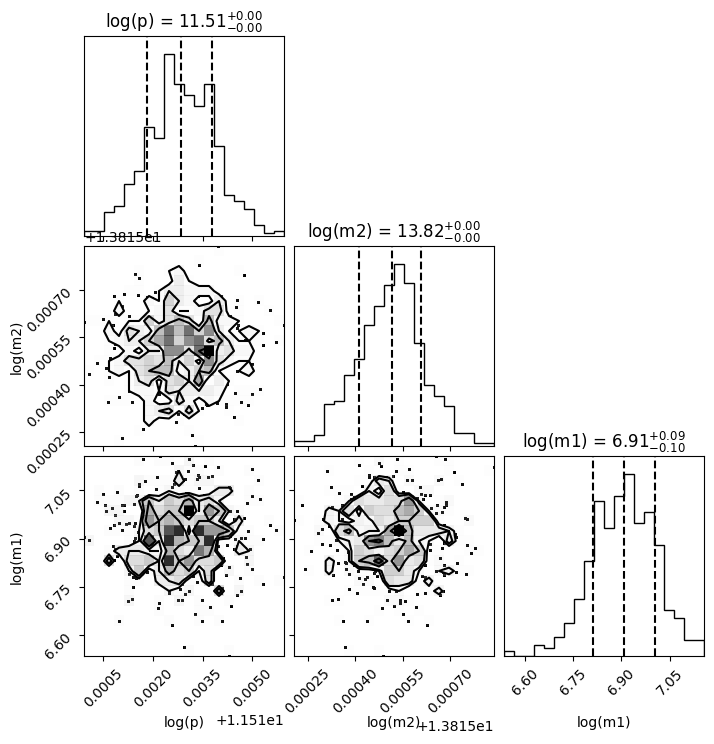

In [11]:

samples[np.argmax(sampler.flatlnprobability)]
log_samples=np.log(samples)
labels = ['log(p)','log(m2)','log(m1)']
fig = corner.corner(log_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
print('nwalkers is', nwalkers)
print('niter is', niter)

In [12]:
# Assuming 'sampler' is your emcee sampler object
acceptance_fractions = sampler.acceptance_fraction

# Print the mean acceptance fraction with one decimal place
print("Mean acceptance fraction: {:.1f}".format(np.mean(acceptance_fractions)))

# Print the acceptance fraction for each walker with two decimal places
for i, af in enumerate(acceptance_fractions):
    print(f"Walker {i+1} acceptance fraction: {af:.2f}")

Mean acceptance fraction: 0.0
Walker 1 acceptance fraction: 0.00
Walker 2 acceptance fraction: 0.00
Walker 3 acceptance fraction: 0.00
Walker 4 acceptance fraction: 0.00
Walker 5 acceptance fraction: 0.00
Walker 6 acceptance fraction: 0.00
Walker 7 acceptance fraction: 0.00
Walker 8 acceptance fraction: 0.00
Walker 9 acceptance fraction: 0.00
Walker 10 acceptance fraction: 0.00
Walker 11 acceptance fraction: 0.00
Walker 12 acceptance fraction: 0.00
Walker 13 acceptance fraction: 0.00
Walker 14 acceptance fraction: 0.00
Walker 15 acceptance fraction: 0.00
Walker 16 acceptance fraction: 0.00
Walker 17 acceptance fraction: 0.00
Walker 18 acceptance fraction: 0.00
Walker 19 acceptance fraction: 0.00
Walker 20 acceptance fraction: 0.00
Walker 21 acceptance fraction: 0.00
Walker 22 acceptance fraction: 0.00
Walker 23 acceptance fraction: 0.00
Walker 24 acceptance fraction: 0.00
Walker 25 acceptance fraction: 0.00
Walker 26 acceptance fraction: 0.00
Walker 27 acceptance fraction: 0.00
Walker 



# Define prior distributions (replace with your knowledge about mass & period)
#add v prior so model can compare its values to it.
vr_prior = norm( loc=1144.188354, scale=10)
mass1_prior = norm(loc=1e35, scale=1e30)  # Assuming a normal prior for mass with mean 1e41 kg (approx 5e10 M) standard dev: random
mass2_prior = norm(loc=1e35, scale=1e30)
period_prior = norm(loc=8e37, scale=1e30)  # Assuming a normal prior for period with mean 1e5 years and std 1e4 years

# Monte Carlo loop
n_simulations = 1000  # Number of simulations
masses = np.zeros(n_simulations)
periods = np.zeros(n_simulations)
accepted = 0

for i in range(n_simulations):
    # Draw samples from priors
    m2 = mass2_prior.rvs()
    m1 = mass1_prior.rvs()
    p = period_prior.rvs()
    vrp=vr_prior.rvs()

    # Simulate OIII line data with the model
    simulated_v = smbh2_model(p, m1, m2)

    # Likelihood function 
    # This should compare the simulated data with our actual OIII line data (flux vs wavelength)
    # and calculate the probability of getting the observed data given the model parameters
    likelihood = np.exp(-np.sum((vrp - simulated_v)**2))

    # Acceptance probability (Metropolis-Hastings)
    acceptance_ratio = likelihood * period_prior.pdf(p) * mass2_prior.pdf(m2)*mass1_prior.pdf(m1)

    # Random number for acceptance decision
    u = np.random.rand()

    if u < acceptance_ratio:
        masses[i] = m2
        periods[i] = p
        accepted += 1

# Analyze results
accepted_fraction = accepted / n_simulations
print(f"Acceptance fraction: {accepted_fraction:.4f}")

# Extract posterior distribution for mass and period
mass_posterior = np.histogram(masses, bins=20)[0] / n_simulations
period_posterior = np.histogram(periods, bins=20)[0] / n_simulations

# Plot results (optional)
plt.hist(masses, bins=20, label="Mass Posterior")
plt.legend()
plt.show()

plt.hist(periods, bins=20, label="Period Posterior")
plt.legend()
plt.show()

# Find maximum a posteriori (MAP) estimates
map_mass = masses[np.argmax(mass_posterior)]
map_period = periods[np.argmax(period_posterior)]

print(likelihood)
print(acceptance_ratio)
print(vrp)
print(simulated_v)
print(f"MAP Mass: {map_mass:.2e} solar masses")
print(f"MAP Period: {map_period:.2e} years")